In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='alexander-prutko', api_key='VocBkhjfvvSy6zHJ8789')

In [4]:
from scipy.stats import multivariate_normal

In [5]:
# параметры распределений
mu0X, mu0Y, sigma0 = -1., -1., 1.
mu1X, mu1Y, sigma1 = 1., 1., 2.

In [6]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [7]:
d0 = torch.distributions.Normal(torch.tensor([mu0X, mu0Y]), torch.tensor([sigma0]))
d1 = torch.distributions.Normal(torch.tensor([mu1X, mu1Y]), torch.tensor([sigma1]))

In [8]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.2690,  0.5709]), tensor(0.4497)]


In [9]:
net = nn.Sequential(nn.Linear(2, 10), nn.SELU(), nn.Linear(10, 10), nn.SELU(), nn.Linear(10, 1))
net_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

In [10]:
layer.cuda()
net.cuda()

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): SELU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): SELU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [11]:
log_freq = 1000
for i in range(50000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(layer(x.cuda()))
            loss = F.binary_cross_entropy(out, y.cuda())
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(layer(x.cuda()))
    loss = F.binary_cross_entropy(out, y.cuda())
    loss.backward()
    layer_opt.step()

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



Ошибка после 0 итераций: 0.680859
Ошибка после 1 итераций: 0.487749
Ошибка после 2 итераций: 0.434112
Ошибка после 3 итераций: 0.414774
Ошибка после 4 итераций: 0.404764
Ошибка после 5 итераций: 0.398399
Ошибка после 6 итераций: 0.397309
Ошибка после 7 итераций: 0.395886
Ошибка после 8 итераций: 0.394772
Ошибка после 9 итераций: 0.396208
Ошибка после 10 итераций: 0.393450
Ошибка после 11 итераций: 0.390529
Ошибка после 12 итераций: 0.393086
Ошибка после 13 итераций: 0.394483
Ошибка после 14 итераций: 0.392344
Ошибка после 15 итераций: 0.393754
Ошибка после 16 итераций: 0.395797
Ошибка после 17 итераций: 0.393599
Ошибка после 18 итераций: 0.396056
Ошибка после 19 итераций: 0.394419
Ошибка после 20 итераций: 0.391521
Ошибка после 21 итераций: 0.392650
Ошибка после 22 итераций: 0.394556
Ошибка после 23 итераций: 0.391974
Ошибка после 24 итераций: 0.392583
Ошибка после 25 итераций: 0.394554
Ошибка после 26 итераций: 0.394766
Ошибка после 27 итераций: 0.393531
Ошибка после 28 итераций: 0.39

In [12]:
nx, ny = (300, 300)
x = np.linspace(-10, 10, nx)
y = np.linspace(-10, 10, ny)
xv, yv = np.meshgrid(x, y)
F0 = multivariate_normal([mu0X, mu0Y], sigma0)
F1 = multivariate_normal([mu1X, mu1Y], sigma1)

grid_list = list(zip(xv.reshape(1,-1).tolist()[0], yv.reshape(1,-1).tolist()[0]))
grid = np.reshape(grid_list, (nx,ny,2))
f0 = F0.pdf(grid)
f1 = F1.pdf(grid)
ratio = f1 / (f1 + f0)
tensor_grid = torch.tensor(grid, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(layer(tensor_grid.cuda())).cpu().numpy()

/media/alex/Data/alex/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning:

nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.



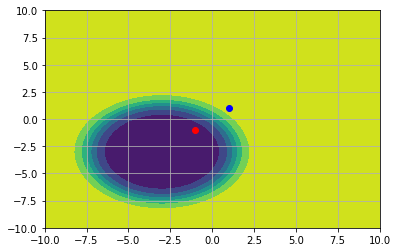

In [13]:
plt.contourf(x,y,ratio)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

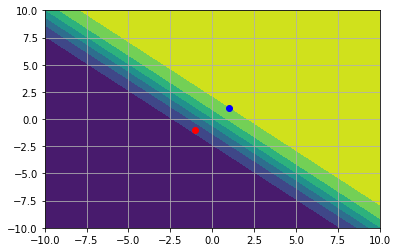

In [14]:
dist = dist.reshape((nx,ny))
h = plt.contourf(x,y,dist)
plt.scatter([-1],[-1], c='red')
plt.scatter([1],[1], c='blue')
plt.grid(True)

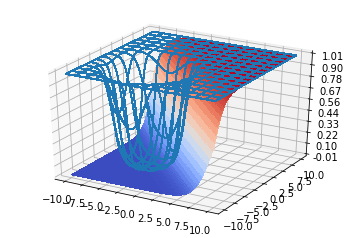

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(xv, yv, dist, cmap=cm.coolwarm, rstride=5, cstride=5,
                       linewidth=0, antialiased=False)
surf = ax.plot_wireframe(xv, yv, ratio, cmap=cm.coolwarm, rstride=20, cstride=20,
                       linewidth=1, antialiased=False)


ax.set_zlim(-0.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

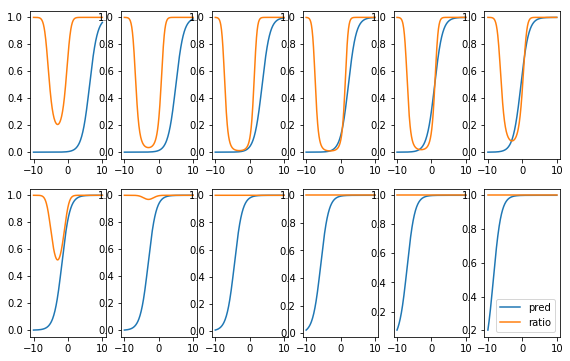

In [16]:
plt.rcParams['figure.figsize'] = [9.5, 6]
yy = 50
for i in range(12):
    plt.subplot(2, 6, i+1)
    plt.plot(x, dist[yy+20*i,:], label='pred')
    plt.plot(x, ratio[yy+20*i,:], label='ratio')
plt.legend();

In [17]:
data = [go.Surface(z=dist, x=xv, y=yv, opacity=1.00, colorscale='Greens'),
        go.Surface(z=ratio, x=xv, y=yv, opacity=0.8)]

In [18]:
py.iplot(data,filename='plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~alexander-prutko/0 or inside your plot.ly account where it is named 'plot'


[plotly plot](https://plot.ly/~alexander-prutko/0)